In [1]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from robustness.tools.label_maps import CLASS_DICT
import os
import sys
sys.path.append('../src')
import pandas as pd
import numpy as np

In [12]:
patch_size = 16

num_patches = 224//patch_size
total_patches = num_patches*num_patches + 1
patch_axis = np.arange(0, total_patches + 1, 2)
root = '/mnt/nfs/home/saachij/src/CausalDomainTransfer/patch_ablation/missingness_results/patch_16_0_0_0'
MODEL_NAMES = [
    'resnet50',
    'resnet50_deitaug',
    'deit_small_patch16_224',
    'deit_small_resnet_aug',
]
mapping_name_ = {
    'resnet50': ('ResNet-50', 'Standard'),
    'resnet50_deitaug': ('ResNet-50', 'CutMix'),
    'deit_small_patch16_224': ('ViT-S', 'CutMix'),
    'deit_small_resnet_aug': ('ViT-S', 'Standard'),
}
skip_factor = 2
root_dirs = {}
for model_name in MODEL_NAMES:
    root_dirs[model_name] = os.path.join(root, model_name)

In [3]:
outs = {}
for model_name in MODEL_NAMES:
    print("===============")
    root_dir = root_dirs[model_name]
    label_map = CLASS_DICT['ImageNet']
    import pickle as pkl
    with open(os.path.join(root_dir, 'envelope.pkl'), 'rb') as f:
        outs[model_name] = pkl.load(f)

In [4]:
import nltk
from nltk.corpus import wordnet as wn
# nltk.download('wordnet')

In [6]:
import json
with open("/mnt/nfs/home/datasets/imagenet_wordnet_info/imagenet_class_index.json", 'r') as f:
    imagenet_cls_idx = json.load(f)

In [7]:
similarities = np.zeros((1000, 1000))
for i in range(1000):
    syn1 = imagenet_cls_idx[str(i)][0]
    num1 = int(syn1.split('n')[1])
    wn1 = wn.synset_from_pos_and_offset('n',num1)
    if i % 10 == 0:
        print(i)
    for j in range(1000):
        syn2 = imagenet_cls_idx[str(j)][0]
        num2 = int(syn2.split('n')[1])
        wn2 = wn.synset_from_pos_and_offset('n',num2)
        similarities[i, j] = wn1.wup_similarity(wn2)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170


KeyboardInterrupt: 

In [8]:
similarities = np.load('../similarities.npy')

In [11]:
patch_axis = 

(99, 10000)

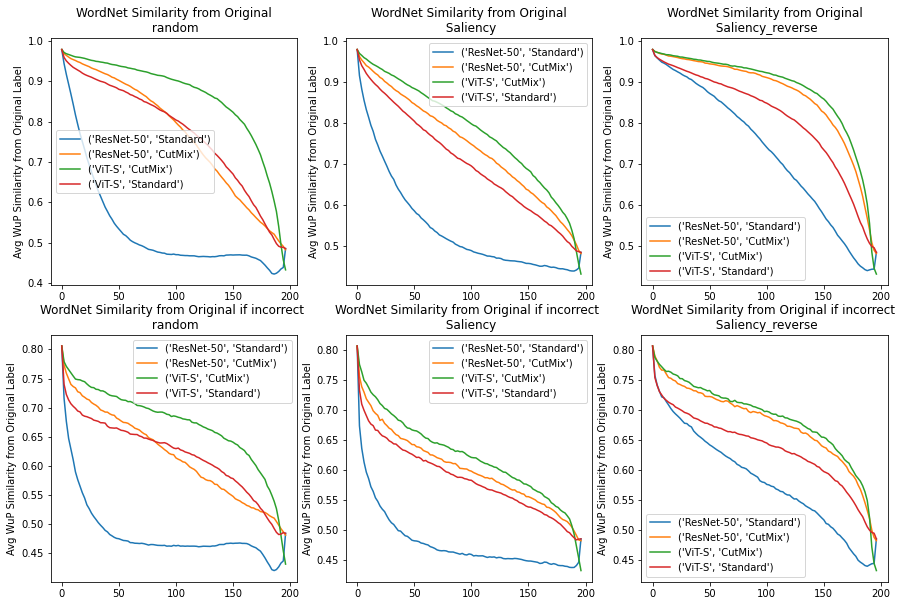

In [22]:
fig, ax = plt.subplots(2, 3, figsize=(15,10))
for model in MODEL_NAMES:
    for idx, method in enumerate(['random', 'Saliency', 'Saliency_reverse']):
        cls_idx = outs[model]['mask_preds'][method].numpy()
        all_sims = []
        for b in range(cls_idx.shape[1]):
            vec = cls_idx[:, b]
            all_sims.append(similarities[vec[0]][vec])
        sim_digression = np.stack(all_sims, axis=1)
        ax[0, idx].plot(patch_axis, sim_digression.mean(-1), label=f"{mapping_name_[model]}")
        sim_digression_nan = np.copy(sim_digression)
        sim_digression_nan[sim_digression_nan == 1] = np.nan
        ax[1, idx].plot(patch_axis, np.nanmean(sim_digression_nan, axis=-1), label=f"{mapping_name_[model]}")
for idx in range(3):
    method_name = ['random', 'Saliency', 'Saliency_reverse'][idx]
    ax[0, idx].set_ylabel('Avg WuP Similarity from Original Label')
    ax[1, idx].set_ylabel('Avg WuP Similarity from Original Label')
    ax[0, idx].set_title(f'WordNet Similarity from Original\n {method_name}')
    ax[1, idx].set_title(f'WordNet Similarity from Original if incorrect \n {method_name}')
    ax[0, idx].legend()
    ax[1, idx].legend()
plt.show()